<a href="https://colab.research.google.com/github/byeongdon/hanghae99/blob/main/1%EC%A3%BC%EC%B0%A8%20%EA%B3%BC%EC%A0%9CA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [57]:
import torch
import torchvision
import torchvision.transforms as transforms

In [58]:
transform = transforms.ToTensor()
batch_size = 256

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

60000
torch.Size([1, 28, 28]) 5


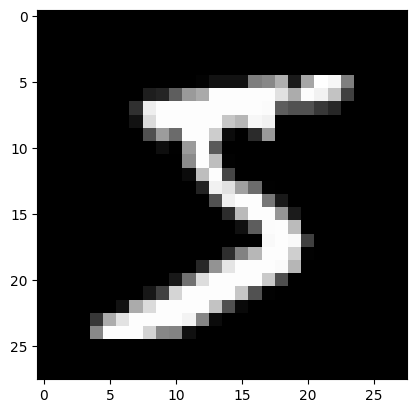

In [59]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

In [60]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


In [61]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(28 * 28 * 1, 1024)

In [62]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

In [63]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [64]:
n_epochs = 100
lose_fn = nn.CrossEntropyLoss()

train_accs = []
test_accs = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    #loss = (preds[:, 0] - labels).pow(2).mean()
    loss = lose_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  for data in testloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)

    loss = lose_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  train_accs.append(accuracy(model, trainloader))
  test_accs.append(accuracy(model, testloader))

  #print(f"train_accs {train_accs}")
  #print(f"test_accs {test_accs}")
  print(f"Epoch {epoch:3d} | Loss: {total_loss}")



Epoch   0 | Loss: 631.2251245975494
Epoch   1 | Loss: 628.2503848075867
Epoch   2 | Loss: 625.2298171520233
Epoch   3 | Loss: 622.0289561748505
Epoch   4 | Loss: 618.5621061325073
Epoch   5 | Loss: 614.756541967392
Epoch   6 | Loss: 610.5022473335266
Epoch   7 | Loss: 605.7455470561981
Epoch   8 | Loss: 600.3615806102753
Epoch   9 | Loss: 594.27769780159
Epoch  10 | Loss: 587.4242470264435
Epoch  11 | Loss: 579.8608775138855
Epoch  12 | Loss: 571.1383022069931
Epoch  13 | Loss: 560.6080501079559
Epoch  14 | Loss: 549.4567304849625
Epoch  15 | Loss: 537.6541783809662
Epoch  16 | Loss: 525.4604314565659
Epoch  17 | Loss: 512.8304260969162
Epoch  18 | Loss: 500.10843443870544
Epoch  19 | Loss: 487.3215682506561
Epoch  20 | Loss: 474.7226400375366
Epoch  21 | Loss: 462.48104310035706
Epoch  22 | Loss: 450.5585734844208
Epoch  23 | Loss: 439.24824249744415
Epoch  24 | Loss: 428.51967334747314
Epoch  25 | Loss: 418.37723529338837
Epoch  26 | Loss: 408.99678885936737
Epoch  27 | Loss: 400.278

In [65]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

tensor([[0.5829, 0.0000, 0.0000, 3.6537, 0.0000, 3.9140, 0.0000, 0.0000, 0.0000,
         0.0000]], device='cuda:0', grad_fn=<ReluBackward0>)
5


In [66]:
import numpy as np

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

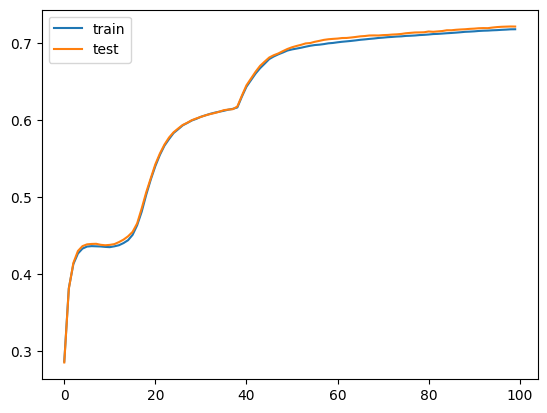

In [67]:
plot_acc(train_accs,test_accs)